In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tensorflow as tf
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, LeakyReLU, BatchNormalization, Conv2DTranspose, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import datasets
from tensorflow.applications import ResNet50


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
class Dataset(object):
  def __init__(self, batch_size, shuffle=False):
      self.batch_size = batch_size
      self.shuffle = shuffle

      train, _ = datasets.mnist.load_data()
      X, y = train
      X = X.astype(np.float32)/255.
      X = X.reshape((X.shape[0], -1))
      self.X = X
      self.y = y

  def __iter__(self):
    N, B = len(self.X), self.batch_size
    idxs = np.arange(N)
    if self.shuffle:
      np.random.shuffle(idxs)
    return iter((self.X[i:i+B], self.y[i:i+B]) for i in range(0, N, B))


dataset = Dataset(batch_size=25, shuffle=True)

dataset.X.shape, dataset.y.shape

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


((60000, 784), (60000,))

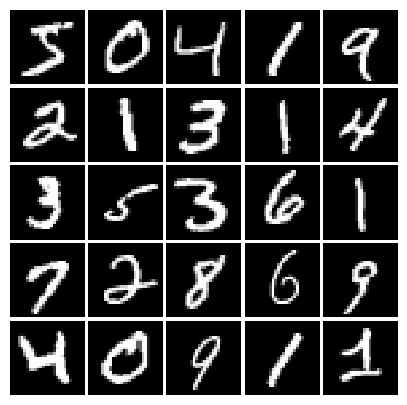

In [3]:
def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

show_images(dataset.X[:25])

In [4]:
def Discriminator_model():
    model = Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=[784]))
    model.add(Reshape([28, 28, 1]))
    model.add(Conv2D(32,(5, 5),strides = 1,padding = 'VALID'))
    model.add(LeakyReLU(0.01))
    model.add(MaxPooling2D((2, 2), strides = 2))
    model.add(Conv2D(64,(5, 5), strides = 1, padding = 'VALID'))
    model.add(LeakyReLU(0.01))
    model.add(MaxPooling2D((2,2), strides = 2))
    model.add(Flatten())
    model.add(LeakyReLU(0.01))
    model.add(Dense(1))
    
    return model

def Generator_model(Noise_dim):
    model = Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=[Noise_dim]))
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(7*7*128, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Reshape([7, 7, 128]))
    model.add(Conv2DTranspose(64,(4,4),strides = 2,activation = 'relu',padding = 'SAME'))
    model.add(BatchNormalization())
    model.add(Conv2DTranspose(1,(4,4),strides = 2,activation = 'tanh',padding = 'SAME'))
    model.add(Flatten())
    
    return model

Discriminator = Discriminator_model()
Generator = Generator_model(100)

Discriminator.summary()
Generator.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape (Reshape)                    │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 24, 24, 32)          │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 8, 8, 64)            │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           1,025 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 53,121 (207.50 KB)

 Trainable params: 53,121 (207.50 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                      │ (None, 1024)                │         103,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6272)                │       6,428,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 6272)                │          25,088 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 14, 14, 64)          │         131,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 28, 28, 1)           │           1,025 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 784)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,693,825 (25.53 MB)

 Trainable params: 6,679,105 (25.48 MB)

 Non-trainable params: 14,720 (57.50 KB)

In [5]:
def discriminator_loss(real_images_output, fake_images_output):
    real_loss = 0.5*tf.reduce_mean(tf.square(real_images_output - 1)) 
    fake_loss = 0.5*tf.reduce_mean(tf.square(fake_images_output - 0))
    return (real_loss + fake_loss)

def generator_loss(fake_images_output):
    loss = 0.5*tf.reduce_mean((tf.square(fake_images_output-1)))
    return loss

def Optimizers():
    Generator_optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0002, beta_1= 0.5)
    Discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0002, beta_1 = 0.5)

    return Generator_optimizer, Discriminator_optimizer

Generator_optimizer, Discriminator_optimizer = Optimizers()

Final images


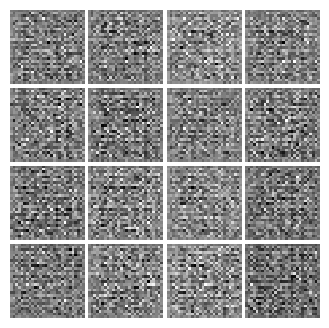

In [6]:
def generate_noise(batch_size, noise_dimension):
    noise = tf.random.uniform(shape=(batch_size, noise_dimension), minval=-1, maxval=1)
    return noise

z = generate_noise(25, 100)
G_sample = Generator(z)
print('Final images')
show_images(G_sample[:16])
plt.show()


Epoch: 0, Iter: 0, D: 0.3477, G:0.4348


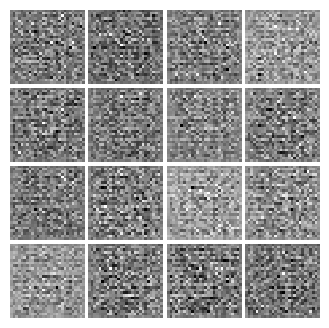

Epoch: 0, Iter: 100, D: 0.01576, G:0.454


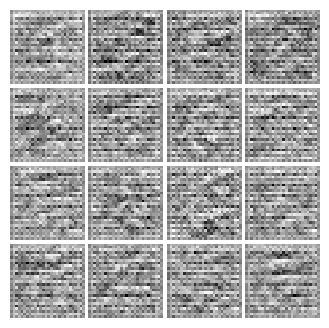

Epoch: 0, Iter: 200, D: 0.01753, G:0.4207


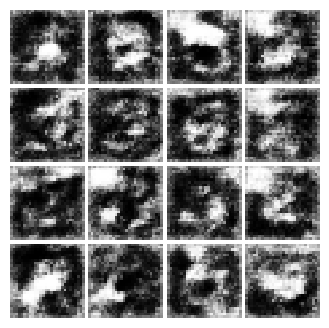

Epoch: 0, Iter: 300, D: 0.04156, G:0.3694


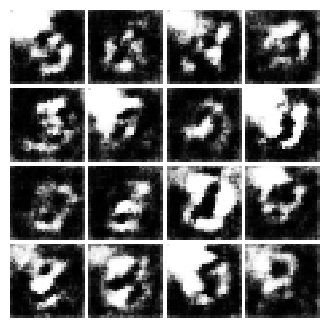

Epoch: 0, Iter: 400, D: 0.09927, G:0.2911


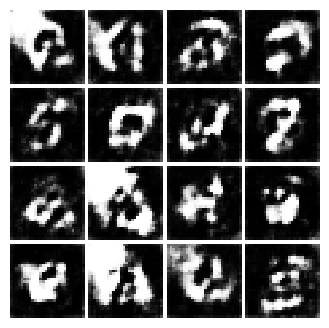

Epoch: 0, Iter: 500, D: 0.1231, G:0.4115


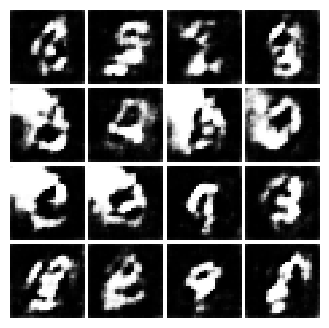

Epoch: 0, Iter: 600, D: 0.08188, G:0.3386


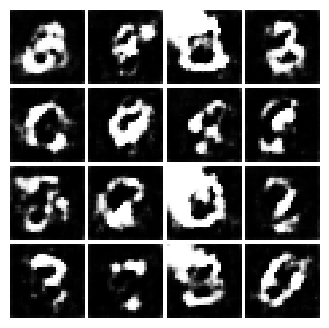

Epoch: 0, Iter: 700, D: 0.09362, G:0.3198


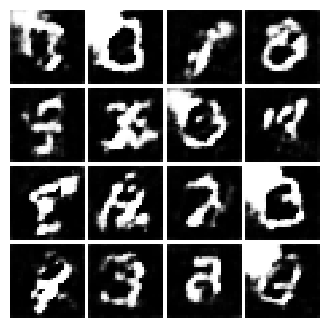

Epoch: 0, Iter: 800, D: 0.09842, G:0.2801


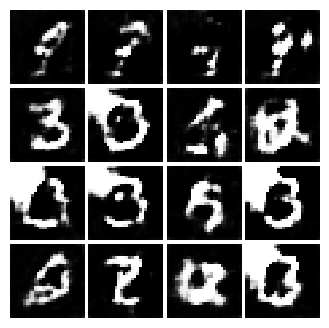

Epoch: 0, Iter: 900, D: 0.1394, G:0.2075


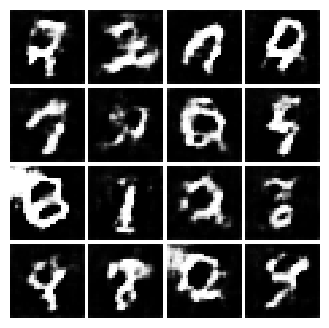

Epoch: 0, Iter: 1000, D: 0.1155, G:0.2212


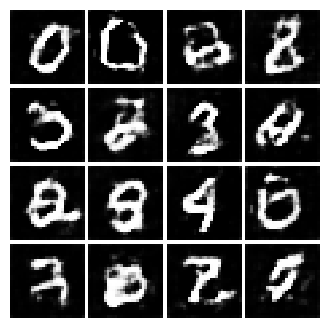

Epoch: 0, Iter: 1100, D: 0.116, G:0.2492


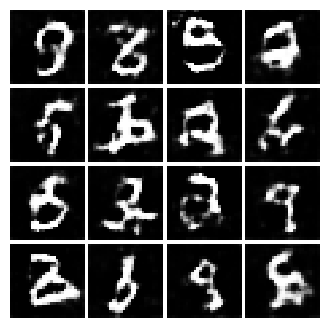

Epoch: 0, Iter: 1200, D: 0.1267, G:0.2217


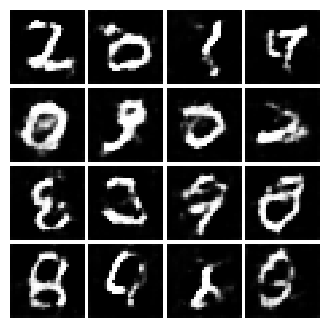

Epoch: 0, Iter: 1300, D: 0.1657, G:0.209


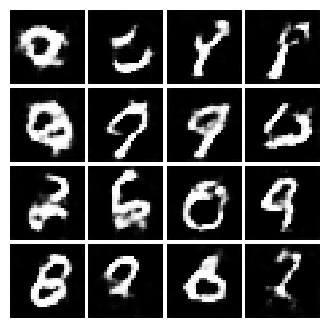

Epoch: 0, Iter: 1400, D: 0.1348, G:0.3244


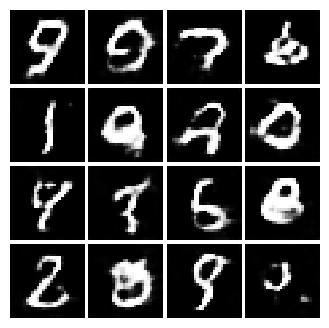

Epoch: 0, Iter: 1500, D: 0.1507, G:0.2585


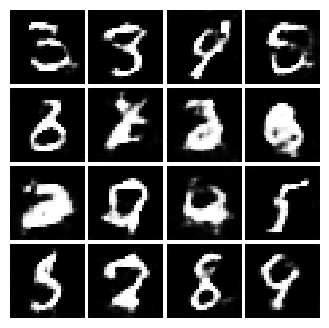

Epoch: 0, Iter: 1600, D: 0.1756, G:0.2254


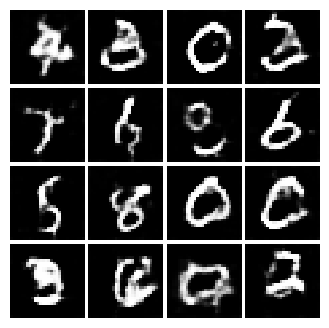

Epoch: 0, Iter: 1700, D: 0.1337, G:0.2743


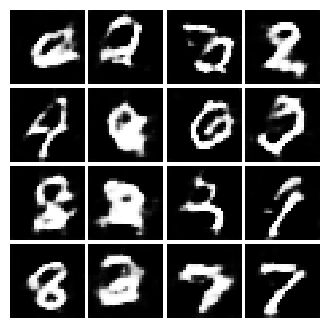

Epoch: 0, Iter: 1800, D: 0.1557, G:0.2526


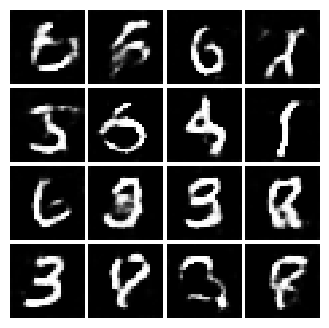

Epoch: 0, Iter: 1900, D: 0.1657, G:0.2012


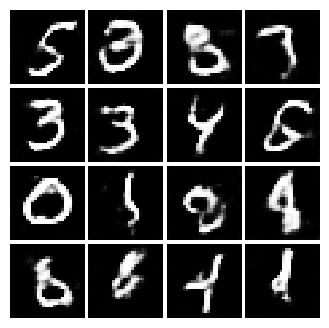

Epoch: 0, Iter: 2000, D: 0.132, G:0.2376


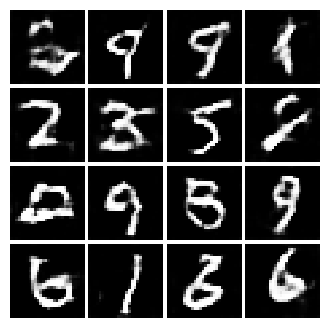

Epoch: 0, Iter: 2100, D: 0.1298, G:0.27


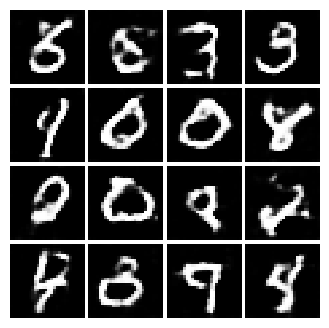

Epoch: 0, Iter: 2200, D: 0.1398, G:0.3666


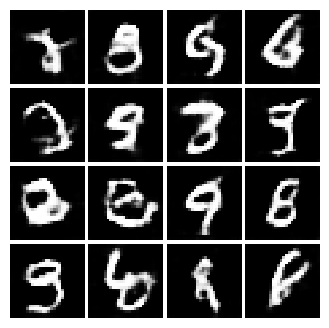

Epoch: 0, Iter: 2300, D: 0.1331, G:0.233


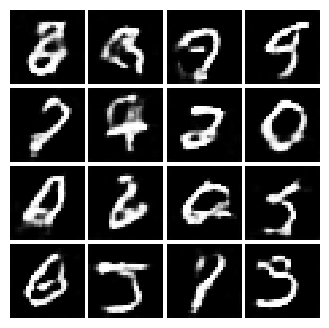

Epoch: 1, Iter: 2400, D: 0.1646, G:0.2199


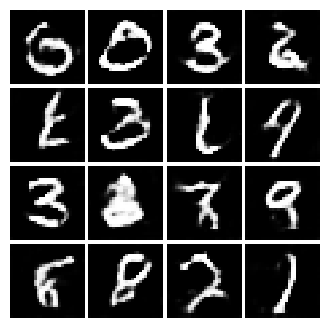

Epoch: 1, Iter: 2500, D: 0.1441, G:0.2444


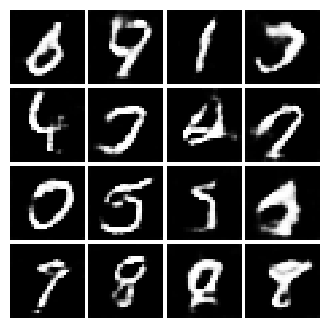

Epoch: 1, Iter: 2600, D: 0.1785, G:0.2266


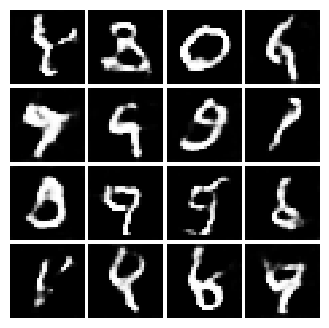

Epoch: 1, Iter: 2700, D: 0.1601, G:0.2225


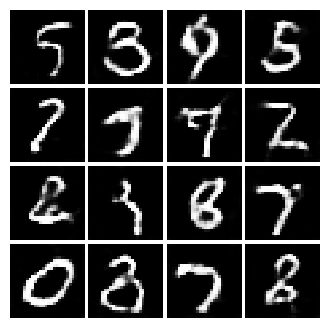

Epoch: 1, Iter: 2800, D: 0.1952, G:0.1442


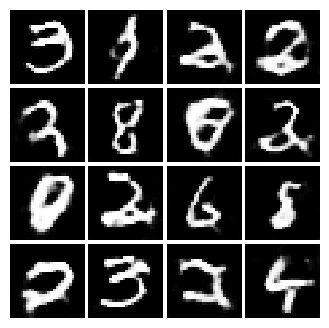

Epoch: 1, Iter: 2900, D: 0.1954, G:0.2192


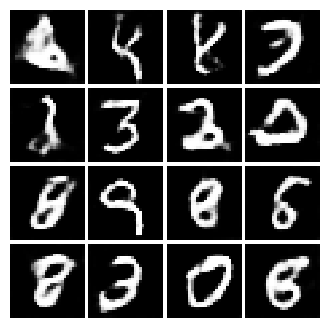

Epoch: 1, Iter: 3000, D: 0.1805, G:0.2514


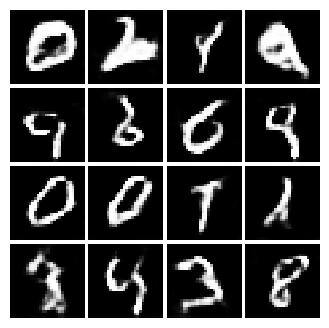

Epoch: 1, Iter: 3100, D: 0.1711, G:0.2253


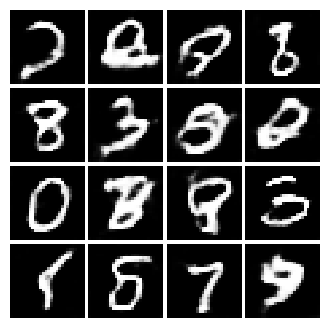

Epoch: 1, Iter: 3200, D: 0.1451, G:0.2351


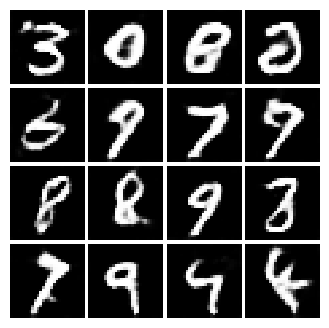

Epoch: 1, Iter: 3300, D: 0.1697, G:0.2702


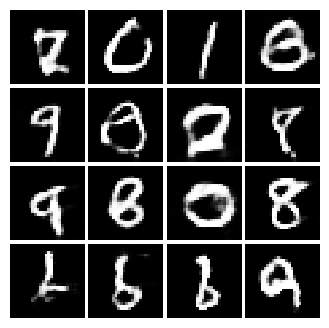

Epoch: 1, Iter: 3400, D: 0.1877, G:0.1824


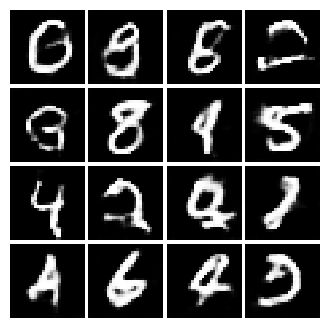

Epoch: 1, Iter: 3500, D: 0.1856, G:0.1749


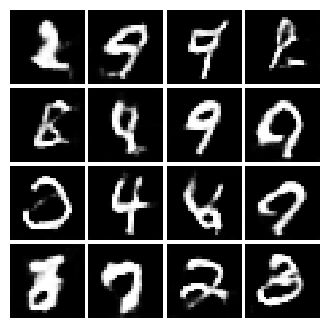

Epoch: 1, Iter: 3600, D: 0.1345, G:0.2691


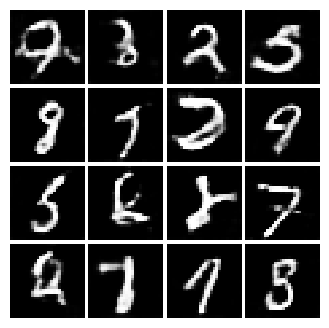

Epoch: 1, Iter: 3700, D: 0.1604, G:0.2315


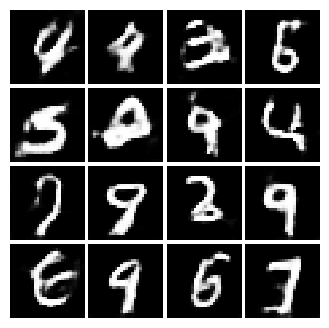

Epoch: 1, Iter: 3800, D: 0.1683, G:0.2383


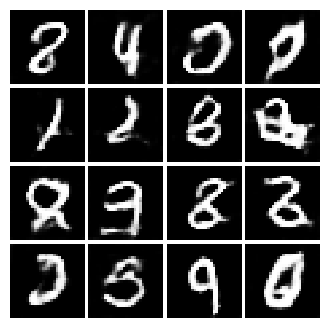

Epoch: 1, Iter: 3900, D: 0.1315, G:0.3119


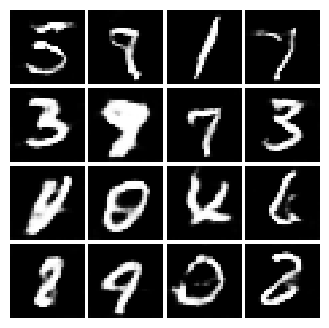

Epoch: 1, Iter: 4000, D: 0.161, G:0.2337


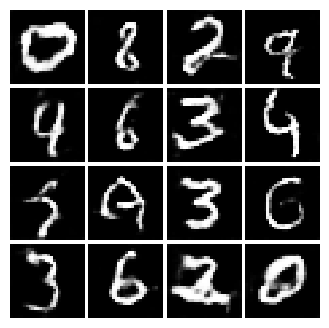

Epoch: 1, Iter: 4100, D: 0.1605, G:0.2307


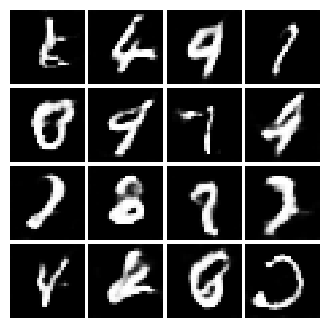

Epoch: 1, Iter: 4200, D: 0.1771, G:0.2996


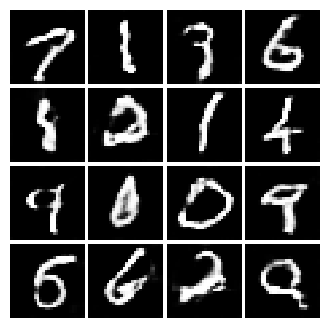

Epoch: 1, Iter: 4300, D: 0.1594, G:0.26


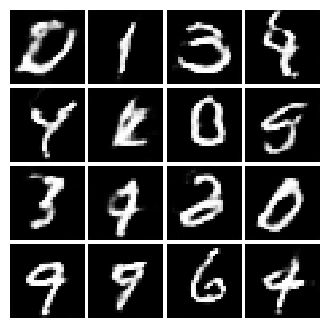

Epoch: 1, Iter: 4400, D: 0.161, G:0.271


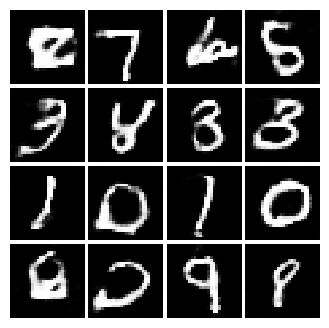

Epoch: 1, Iter: 4500, D: 0.1666, G:0.3259


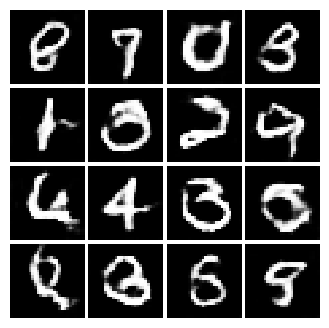

Epoch: 1, Iter: 4600, D: 0.1349, G:0.4109


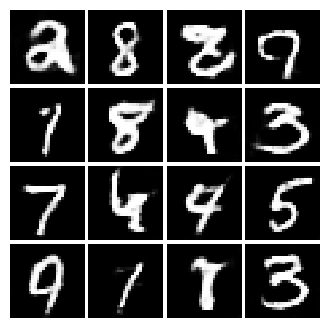

Epoch: 1, Iter: 4700, D: 0.1617, G:0.2961


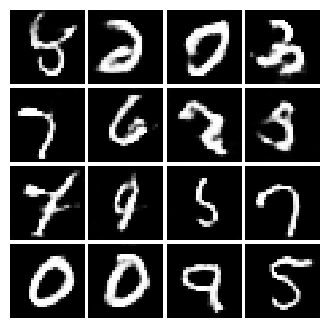

Epoch: 2, Iter: 4800, D: 0.2019, G:0.2387


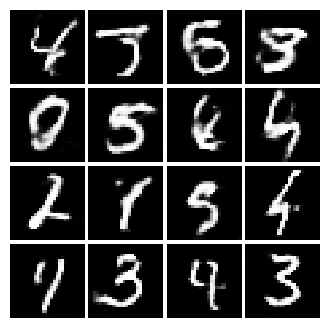

Epoch: 2, Iter: 4900, D: 0.1608, G:0.212


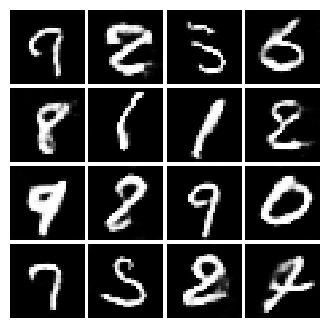

Epoch: 2, Iter: 5000, D: 0.192, G:0.2056


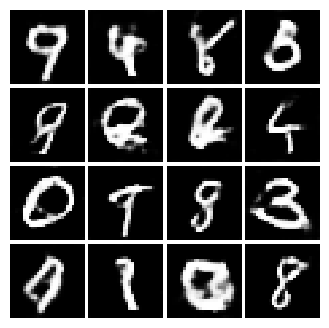

Epoch: 2, Iter: 5100, D: 0.1449, G:0.2699


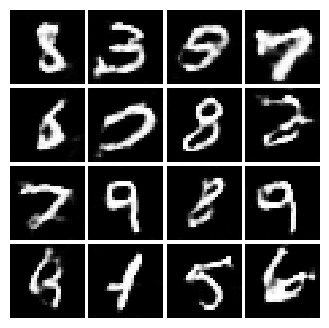

Epoch: 2, Iter: 5200, D: 0.1897, G:0.1405


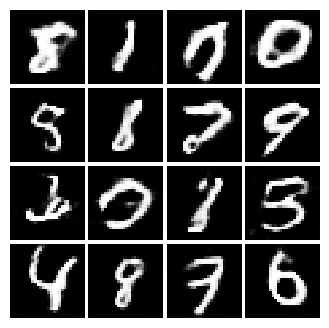

Epoch: 2, Iter: 5300, D: 0.195, G:0.2269


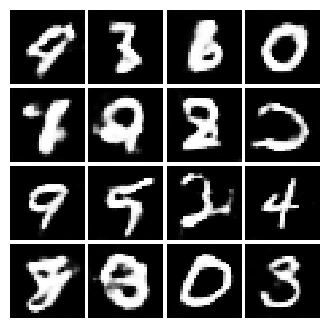

Epoch: 2, Iter: 5400, D: 0.1592, G:0.2179


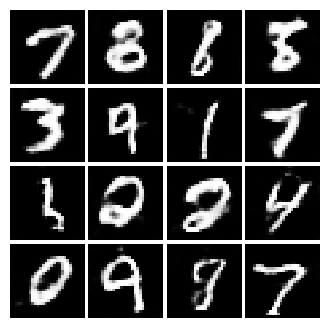

Epoch: 2, Iter: 5500, D: 0.1997, G:0.2352


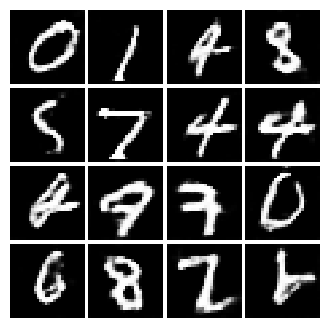

Epoch: 2, Iter: 5600, D: 0.139, G:0.1823


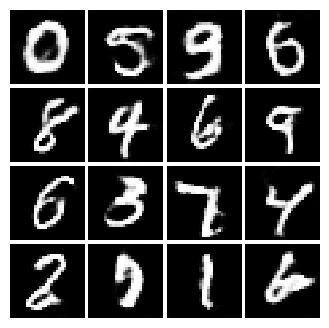

Epoch: 2, Iter: 5700, D: 0.1524, G:0.2843


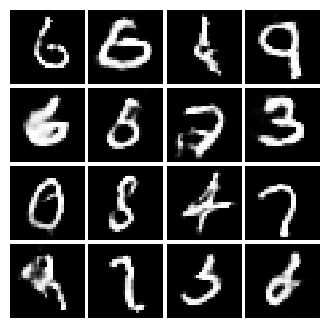

Epoch: 2, Iter: 5800, D: 0.1985, G:0.1758


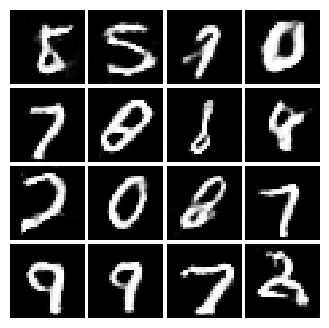

Epoch: 2, Iter: 5900, D: 0.165, G:0.2441


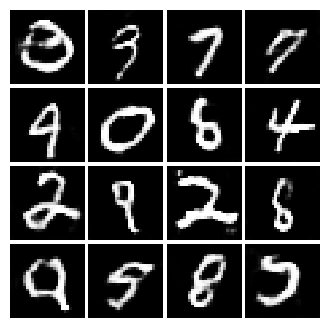

Epoch: 2, Iter: 6000, D: 0.1241, G:0.2846


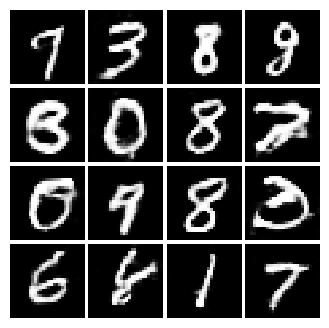

Epoch: 2, Iter: 6100, D: 0.153, G:0.2481


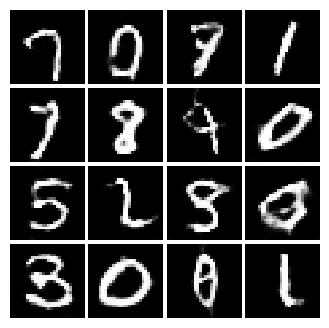

Epoch: 2, Iter: 6200, D: 0.1464, G:0.2482


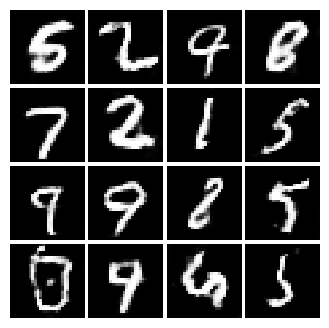

Epoch: 2, Iter: 6300, D: 0.1452, G:0.2318


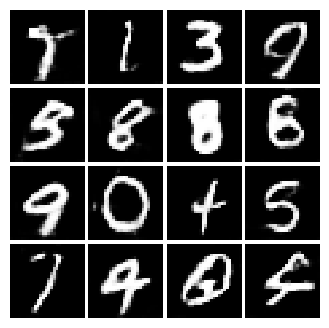

Epoch: 2, Iter: 6400, D: 0.1624, G:0.2309


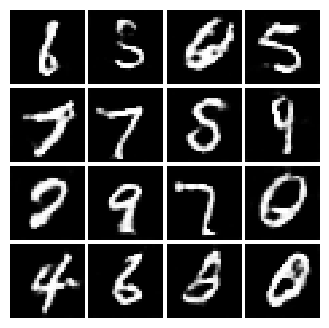

Epoch: 2, Iter: 6500, D: 0.1474, G:0.1661


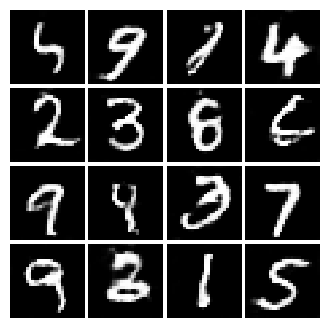

Epoch: 2, Iter: 6600, D: 0.1915, G:0.234


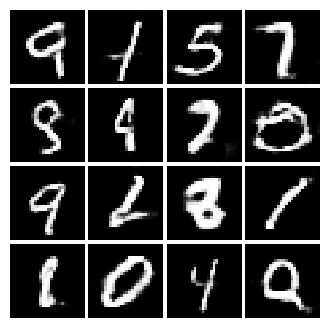

Epoch: 2, Iter: 6700, D: 0.1723, G:0.2398


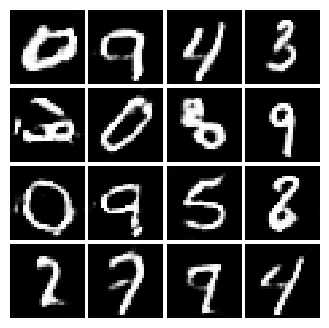

Epoch: 2, Iter: 6800, D: 0.1657, G:0.2719


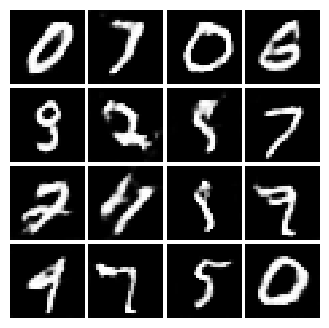

Epoch: 2, Iter: 6900, D: 0.1951, G:0.2652


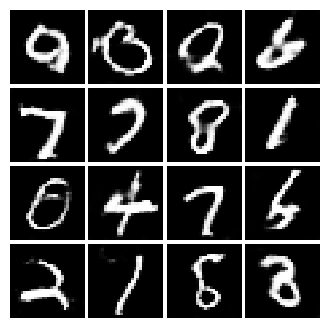

Epoch: 2, Iter: 7000, D: 0.1265, G:0.2634


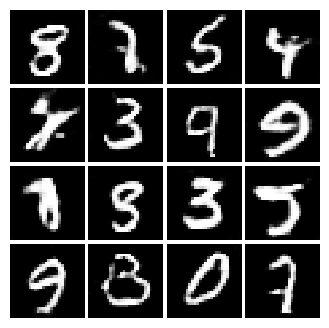

Epoch: 2, Iter: 7100, D: 0.1477, G:0.2824


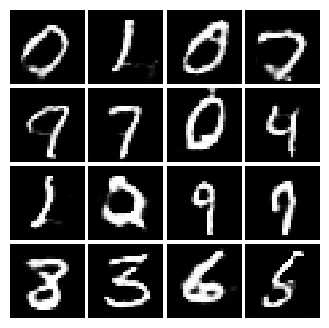

Epoch: 3, Iter: 7200, D: 0.1979, G:0.2227


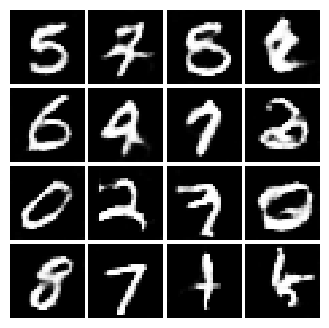

Epoch: 3, Iter: 7300, D: 0.1372, G:0.2521


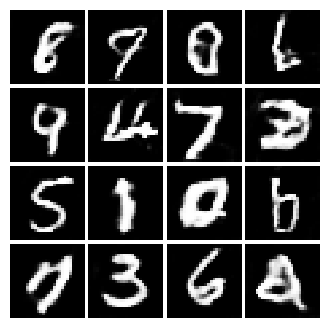

Epoch: 3, Iter: 7400, D: 0.1699, G:0.2016


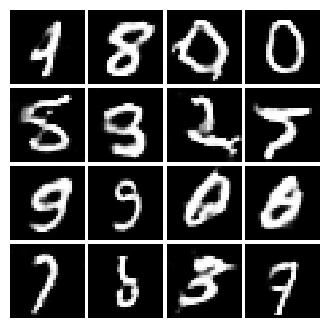

Epoch: 3, Iter: 7500, D: 0.1611, G:0.2285


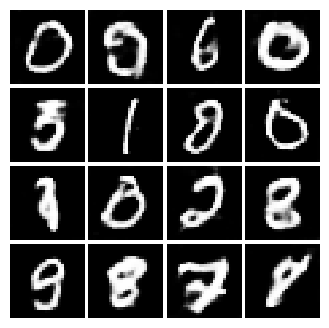

Epoch: 3, Iter: 7600, D: 0.2067, G:0.1788


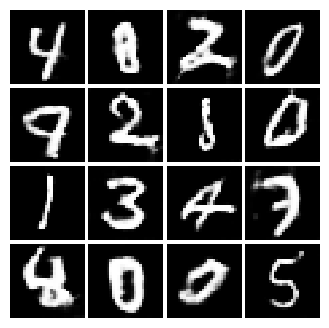

Epoch: 3, Iter: 7700, D: 0.1568, G:0.2616


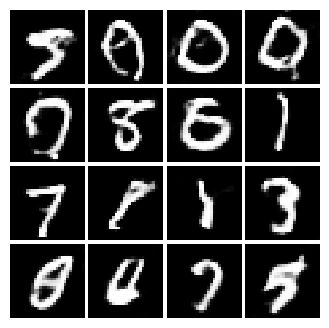

Epoch: 3, Iter: 7800, D: 0.1645, G:0.2237


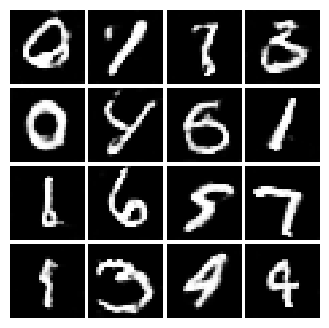

Epoch: 3, Iter: 7900, D: 0.1798, G:0.1777


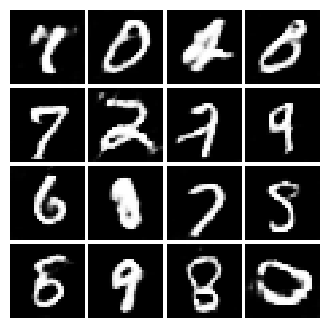

Epoch: 3, Iter: 8000, D: 0.1198, G:0.2622


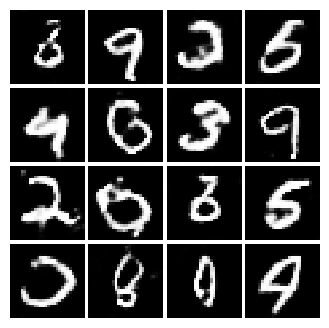

Epoch: 3, Iter: 8100, D: 0.188, G:0.2363


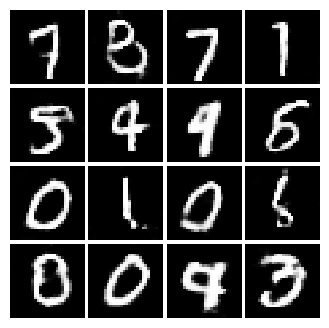

Epoch: 3, Iter: 8200, D: 0.1984, G:0.212


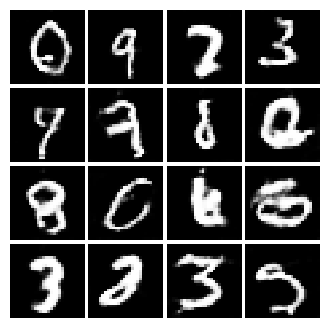

Epoch: 3, Iter: 8300, D: 0.1784, G:0.2361


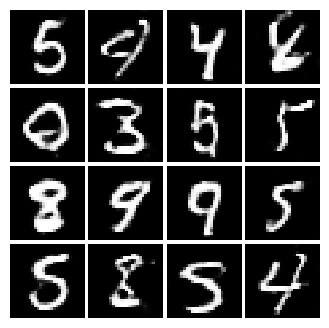

Epoch: 3, Iter: 8400, D: 0.1135, G:0.2933


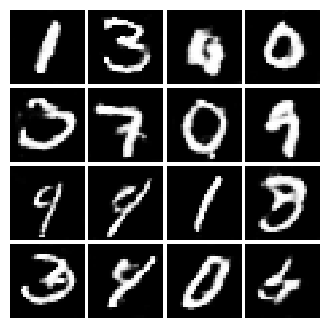

Epoch: 3, Iter: 8500, D: 0.1573, G:0.1833


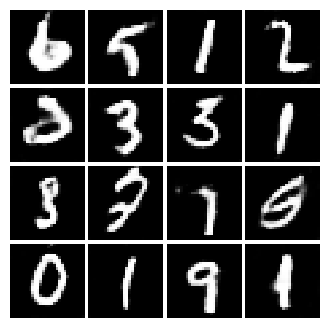

Epoch: 3, Iter: 8600, D: 0.1527, G:0.2653


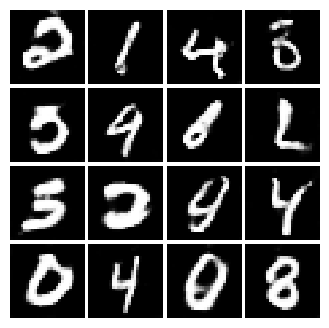

Epoch: 3, Iter: 8700, D: 0.1545, G:0.2314


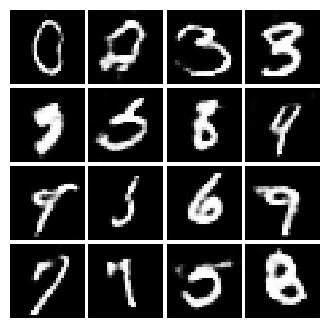

Epoch: 3, Iter: 8800, D: 0.1425, G:0.2111


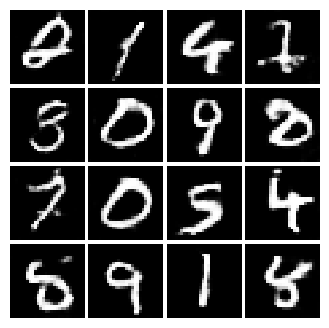

Epoch: 3, Iter: 8900, D: 0.1411, G:0.2109


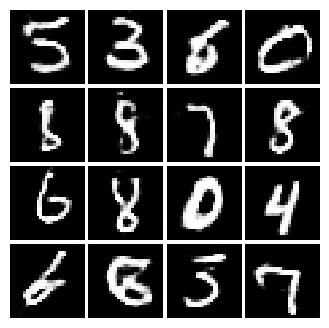

Epoch: 3, Iter: 9000, D: 0.186, G:0.2178


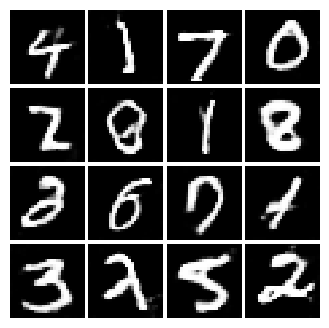

Epoch: 3, Iter: 9100, D: 0.1906, G:0.2841


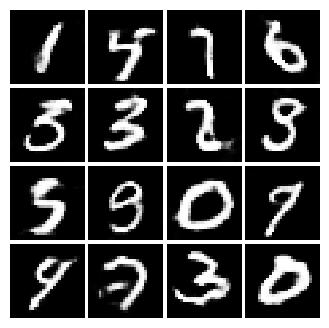

Epoch: 3, Iter: 9200, D: 0.1359, G:0.2651


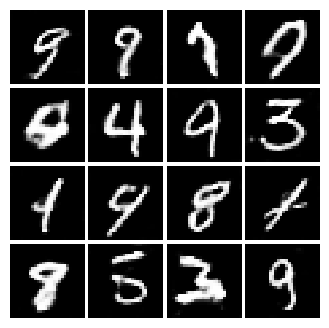

Epoch: 3, Iter: 9300, D: 0.1324, G:0.1374


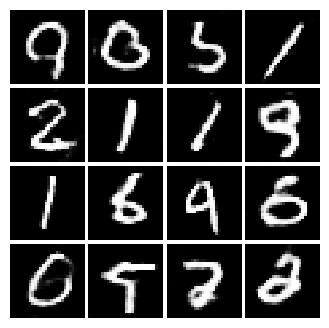

Epoch: 3, Iter: 9400, D: 0.1327, G:0.3944


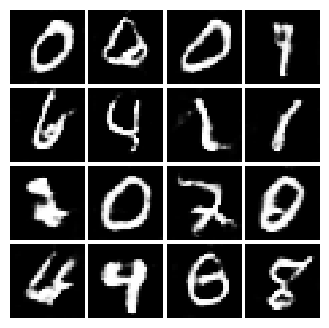

Epoch: 3, Iter: 9500, D: 0.1312, G:0.3438


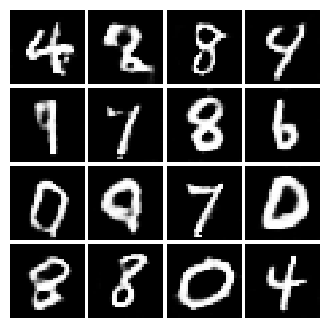

Epoch: 4, Iter: 9600, D: 0.1935, G:0.2253


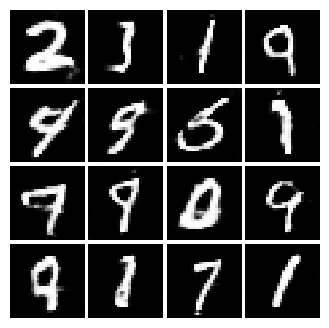

Epoch: 4, Iter: 9700, D: 0.1466, G:0.2255


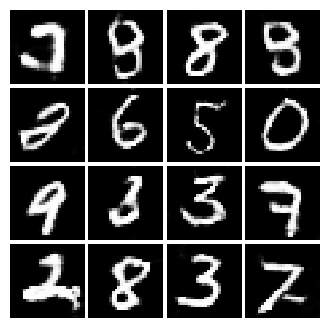

Epoch: 4, Iter: 9800, D: 0.1748, G:0.2518


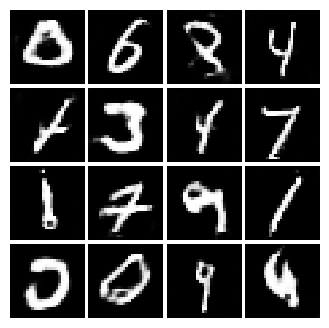

Epoch: 4, Iter: 9900, D: 0.1395, G:0.2546


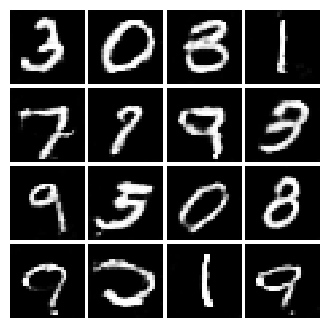

Epoch: 4, Iter: 10000, D: 0.2313, G:0.1918


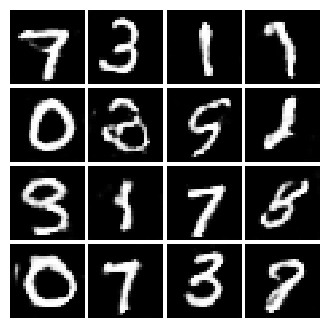

Epoch: 4, Iter: 10100, D: 0.1441, G:0.2166


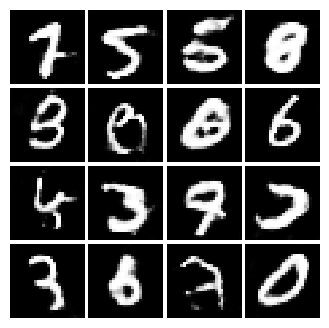

Epoch: 4, Iter: 10200, D: 0.1869, G:0.1718


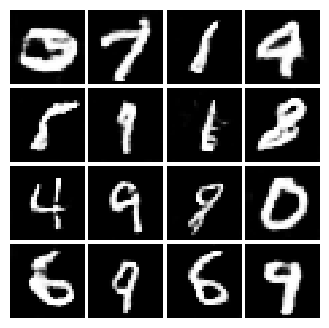

Epoch: 4, Iter: 10300, D: 0.1839, G:0.2193


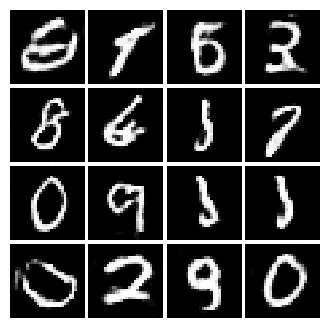

Epoch: 4, Iter: 10400, D: 0.119, G:0.2389


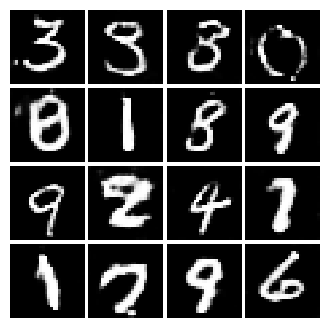

Epoch: 4, Iter: 10500, D: 0.1593, G:0.2865


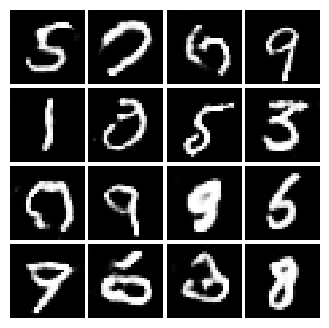

Epoch: 4, Iter: 10600, D: 0.2015, G:0.2335


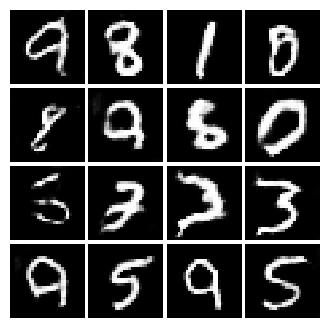

Epoch: 4, Iter: 10700, D: 0.1866, G:0.2265


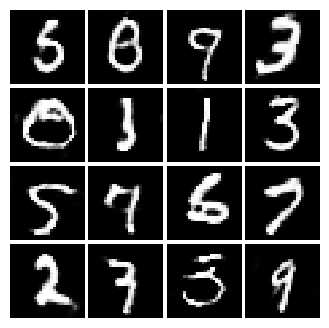

Epoch: 4, Iter: 10800, D: 0.1207, G:0.2406


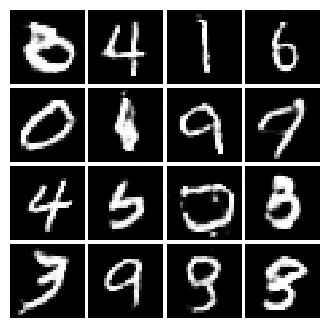

Epoch: 4, Iter: 10900, D: 0.134, G:0.22


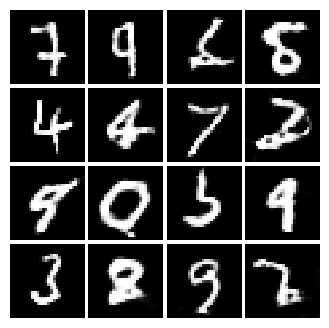

Epoch: 4, Iter: 11000, D: 0.1486, G:0.1809


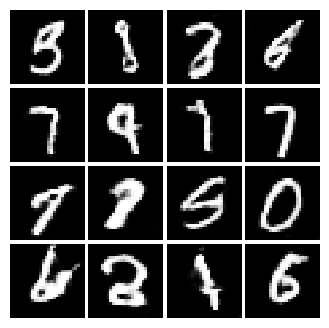

Epoch: 4, Iter: 11100, D: 0.1667, G:0.2735


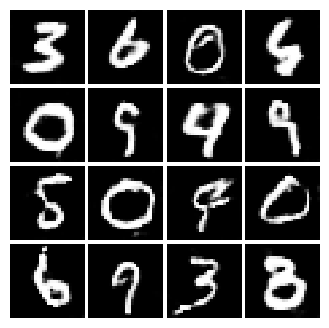

Epoch: 4, Iter: 11200, D: 0.1557, G:0.2834


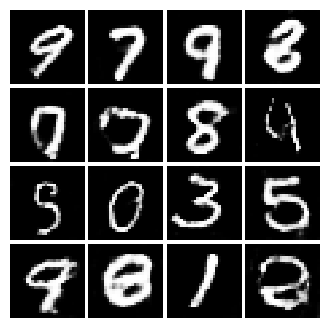

Epoch: 4, Iter: 11300, D: 0.1519, G:0.2542


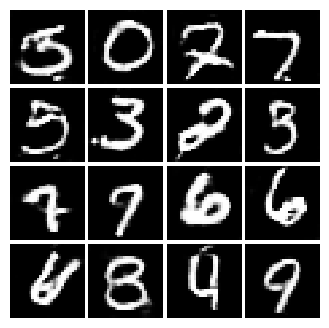

Epoch: 4, Iter: 11400, D: 0.1577, G:0.1854


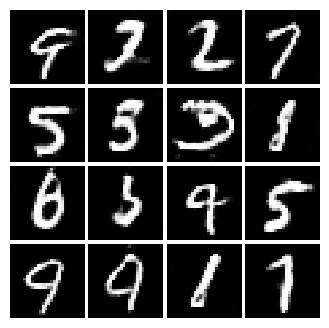

Epoch: 4, Iter: 11500, D: 0.1846, G:0.2429


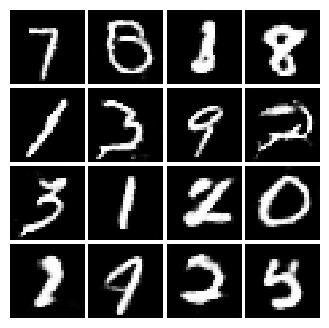

Epoch: 4, Iter: 11600, D: 0.1527, G:0.2393


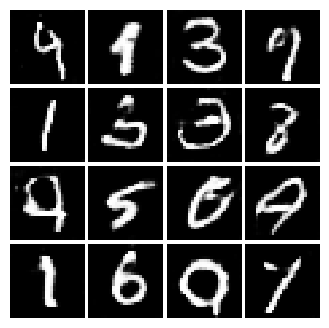

Epoch: 4, Iter: 11700, D: 0.1399, G:0.2023


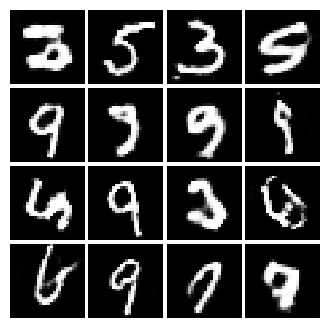

Epoch: 4, Iter: 11800, D: 0.142, G:0.2955


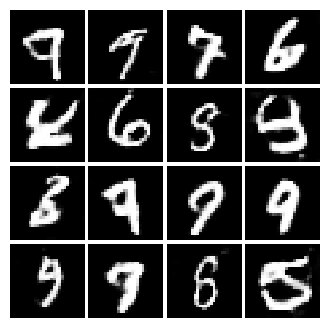

Epoch: 4, Iter: 11900, D: 0.1394, G:0.3556


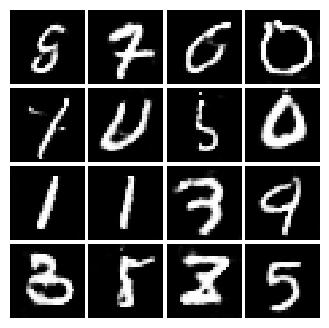

Epoch: 5, Iter: 12000, D: 0.2428, G:0.1755


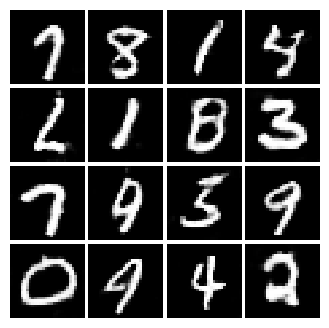

Epoch: 5, Iter: 12100, D: 0.1351, G:0.192


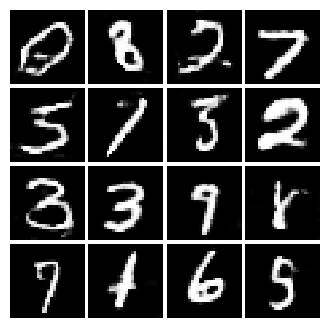

Epoch: 5, Iter: 12200, D: 0.1734, G:0.2393


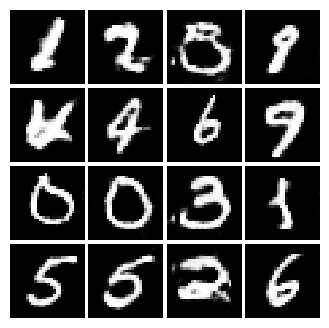

Epoch: 5, Iter: 12300, D: 0.1445, G:0.2356


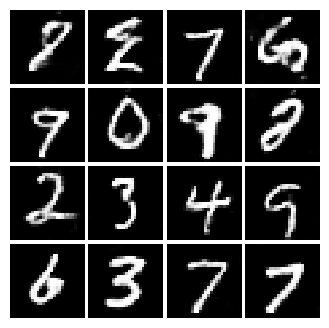

Epoch: 5, Iter: 12400, D: 0.2264, G:0.1901


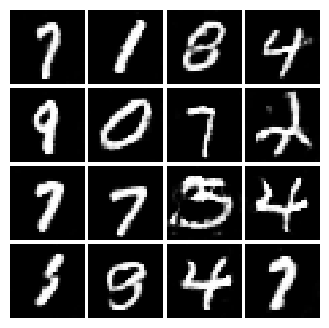

Epoch: 5, Iter: 12500, D: 0.1798, G:0.2551


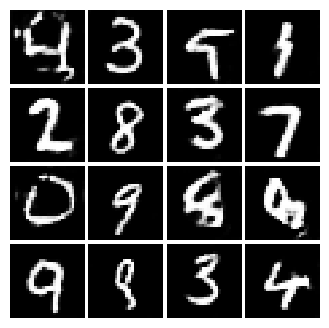

Epoch: 5, Iter: 12600, D: 0.1683, G:0.2424


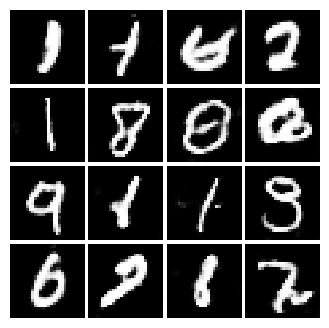

Epoch: 5, Iter: 12700, D: 0.1617, G:0.156


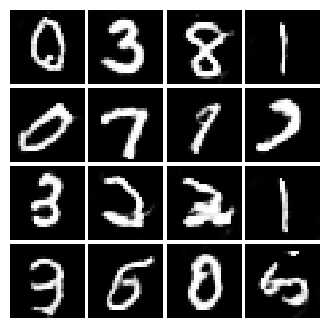

Epoch: 5, Iter: 12800, D: 0.149, G:0.2757


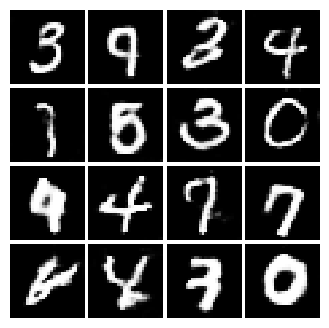

Epoch: 5, Iter: 12900, D: 0.1483, G:0.231


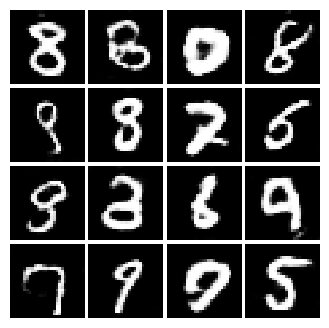

Epoch: 5, Iter: 13000, D: 0.1969, G:0.1948


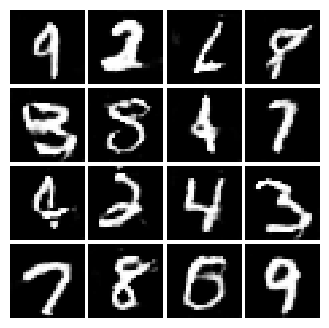

Epoch: 5, Iter: 13100, D: 0.1319, G:0.2566


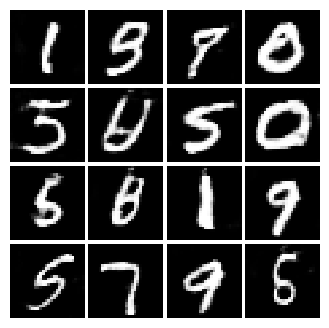

Epoch: 5, Iter: 13200, D: 0.1115, G:0.3079


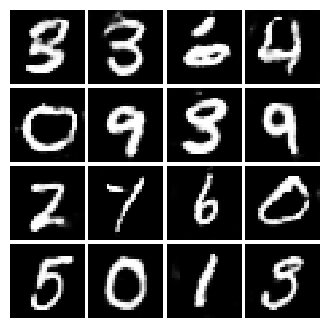

Epoch: 5, Iter: 13300, D: 0.1503, G:0.1958


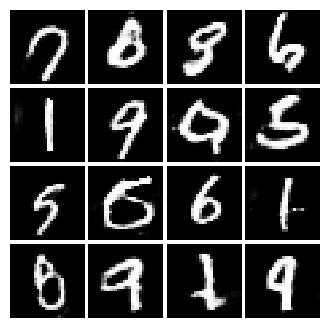

Epoch: 5, Iter: 13400, D: 0.1506, G:0.2191


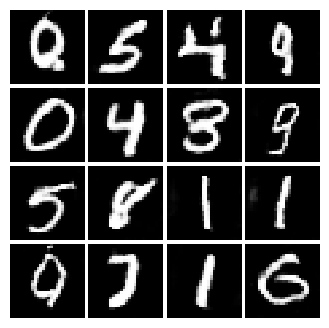

Epoch: 5, Iter: 13500, D: 0.1643, G:0.2521


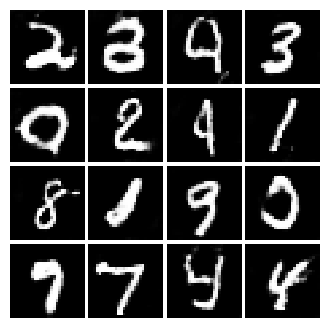

Epoch: 5, Iter: 13600, D: 0.1685, G:0.2794


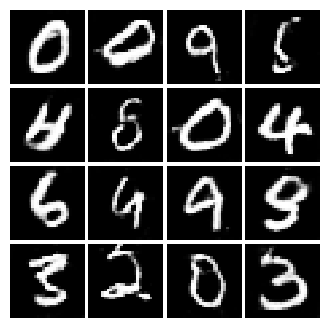

Epoch: 5, Iter: 13700, D: 0.1466, G:0.2082


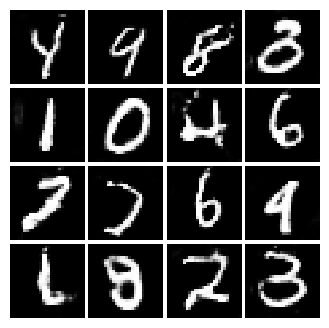

Epoch: 5, Iter: 13800, D: 0.18, G:0.2217


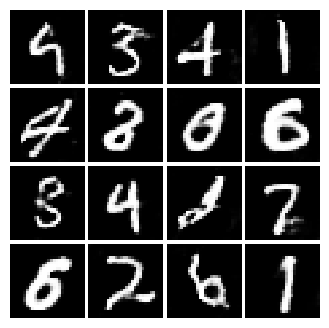

Epoch: 5, Iter: 13900, D: 0.1668, G:0.2885


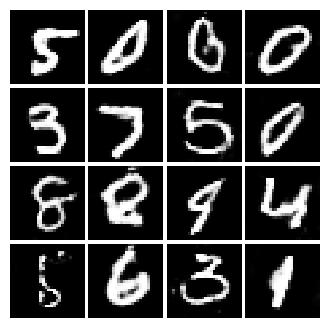

Epoch: 5, Iter: 14000, D: 0.1442, G:0.1863


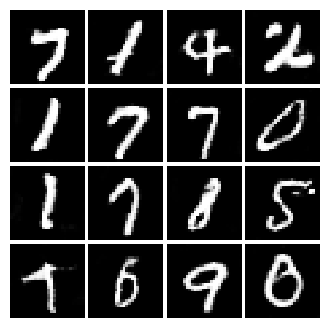

Epoch: 5, Iter: 14100, D: 0.1619, G:0.2466


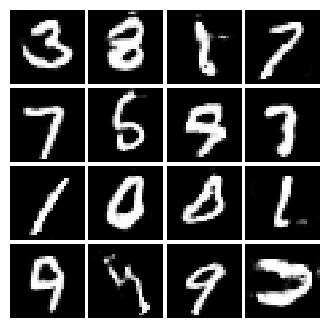

Epoch: 5, Iter: 14200, D: 0.1312, G:0.3274


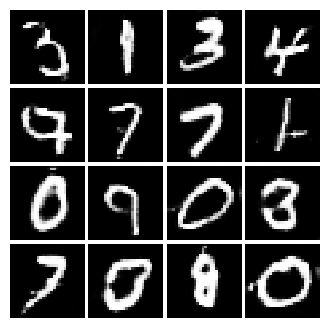

Epoch: 5, Iter: 14300, D: 0.1231, G:0.3476


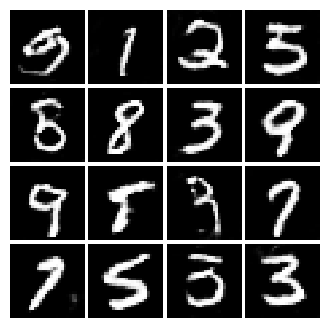

Epoch: 6, Iter: 14400, D: 0.1942, G:0.2466


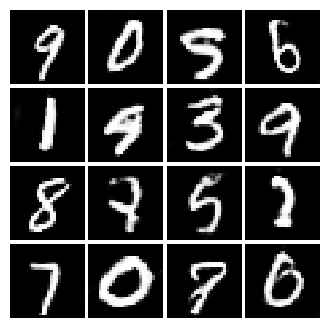

Epoch: 6, Iter: 14500, D: 0.1471, G:0.1796


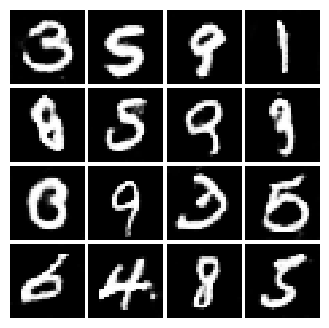

Epoch: 6, Iter: 14600, D: 0.1842, G:0.2584


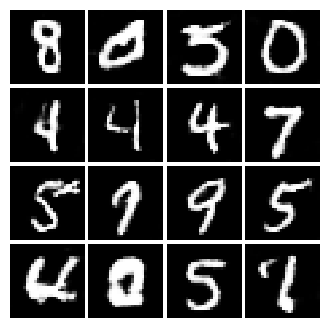

Epoch: 6, Iter: 14700, D: 0.1247, G:0.2213


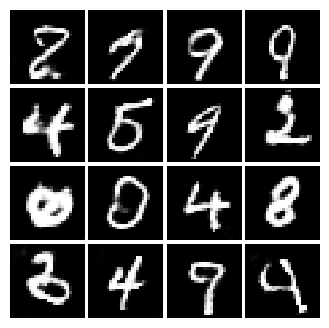

Epoch: 6, Iter: 14800, D: 0.2011, G:0.1381


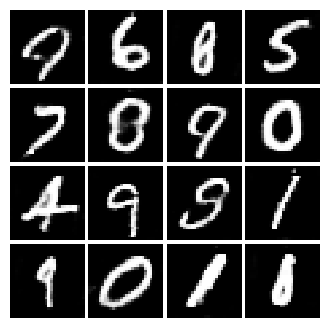

Epoch: 6, Iter: 14900, D: 0.2045, G:0.2875


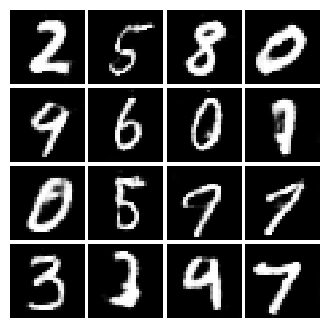

Epoch: 6, Iter: 15000, D: 0.2122, G:0.1725


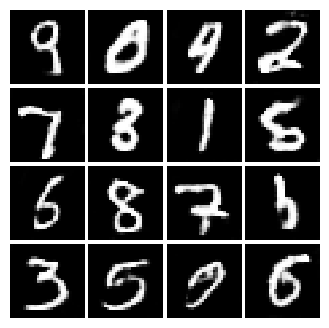

Epoch: 6, Iter: 15100, D: 0.1693, G:0.2213


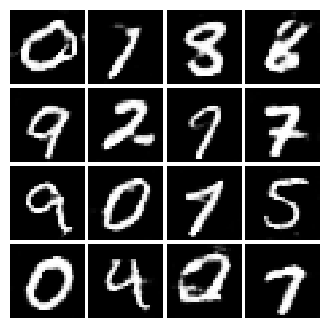

Epoch: 6, Iter: 15200, D: 0.128, G:0.2414


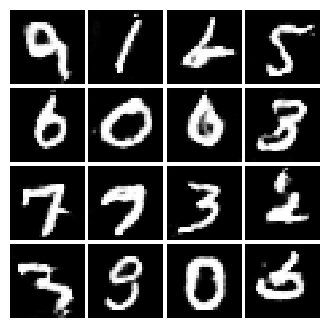

Epoch: 6, Iter: 15300, D: 0.1419, G:0.2492


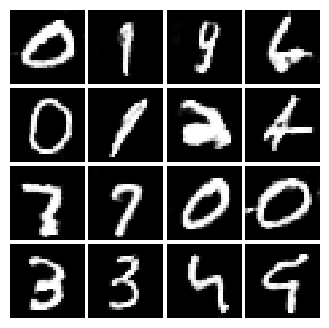

Epoch: 6, Iter: 15400, D: 0.1716, G:0.2438


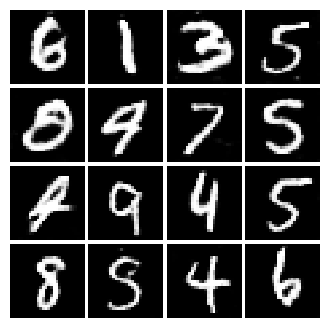

Epoch: 6, Iter: 15500, D: 0.1444, G:0.257


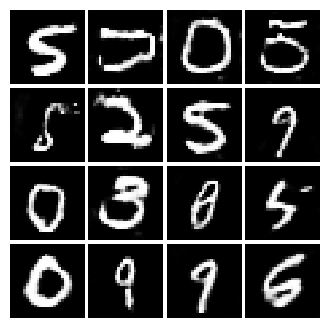

Epoch: 6, Iter: 15600, D: 0.1159, G:0.3126


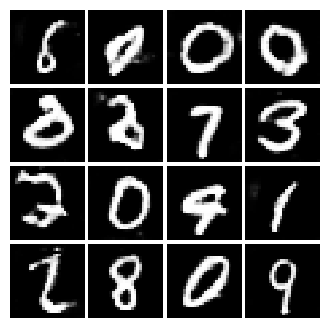

Epoch: 6, Iter: 15700, D: 0.1695, G:0.2519


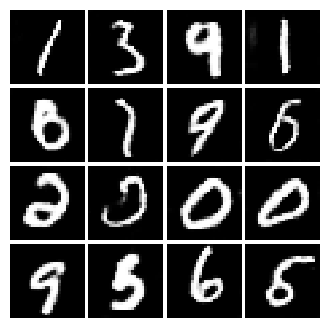

Epoch: 6, Iter: 15800, D: 0.1764, G:0.2705


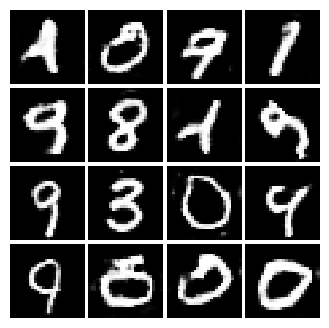

Epoch: 6, Iter: 15900, D: 0.1418, G:0.2449


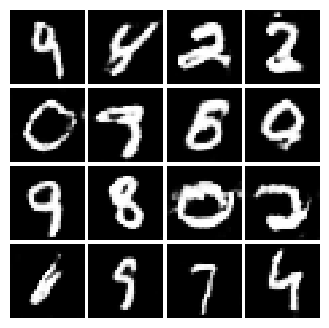

Epoch: 6, Iter: 16000, D: 0.1912, G:0.3273


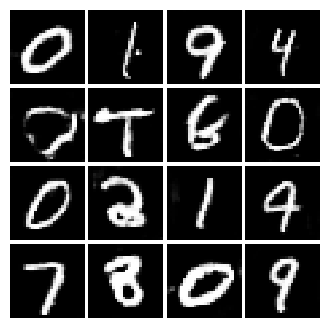

Epoch: 6, Iter: 16100, D: 0.1359, G:0.2176


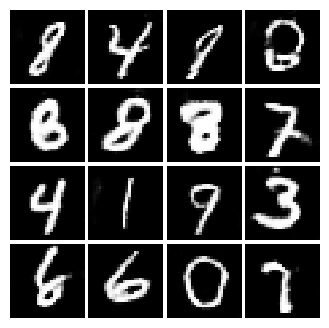

Epoch: 6, Iter: 16200, D: 0.2007, G:0.1902


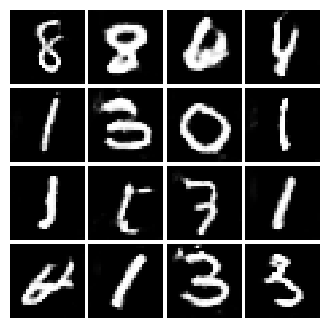

Epoch: 6, Iter: 16300, D: 0.1333, G:0.2625


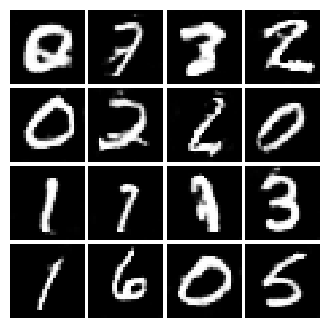

Epoch: 6, Iter: 16400, D: 0.1353, G:0.1979


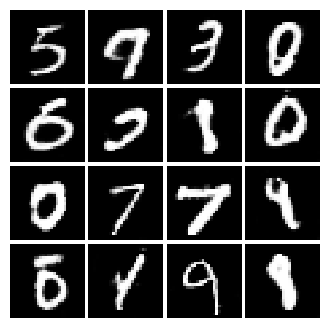

Epoch: 6, Iter: 16500, D: 0.1402, G:0.1849


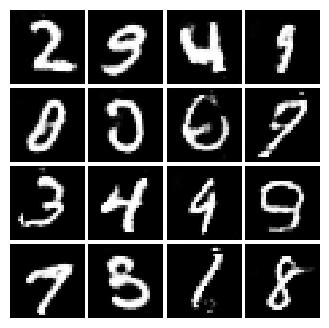

Epoch: 6, Iter: 16600, D: 0.1212, G:0.3264


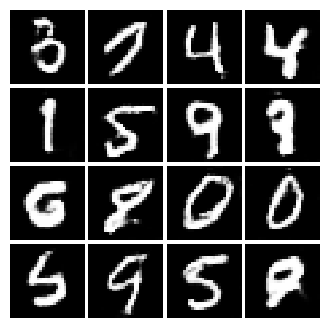

Epoch: 6, Iter: 16700, D: 0.1252, G:0.3398


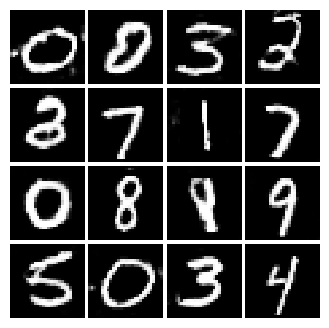

Epoch: 7, Iter: 16800, D: 0.2118, G:0.2333


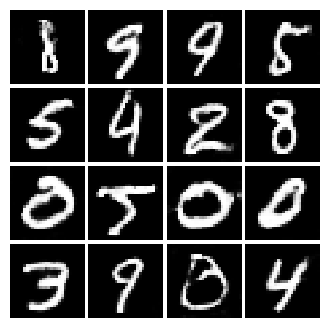

Epoch: 7, Iter: 16900, D: 0.1346, G:0.199


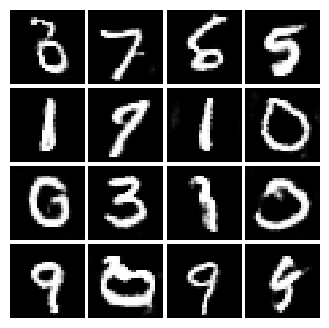

Epoch: 7, Iter: 17000, D: 0.168, G:0.1677


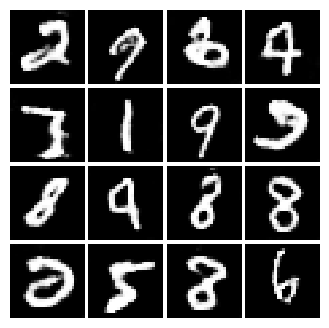

Epoch: 7, Iter: 17100, D: 0.1544, G:0.2294


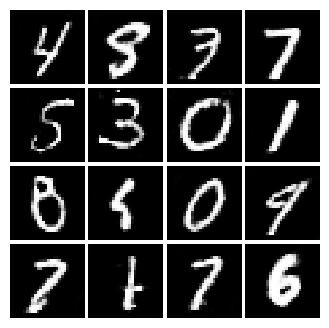

Epoch: 7, Iter: 17200, D: 0.1947, G:0.1237


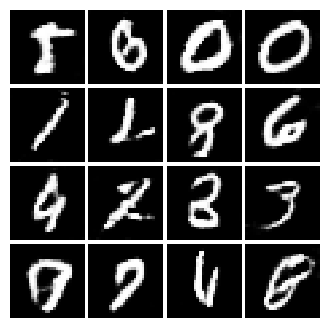

Epoch: 7, Iter: 17300, D: 0.1566, G:0.2698


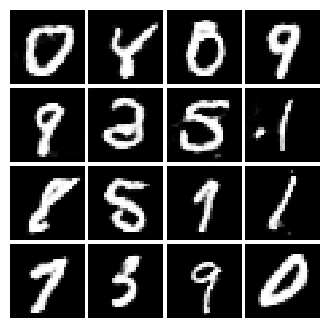

Epoch: 7, Iter: 17400, D: 0.1608, G:0.2526


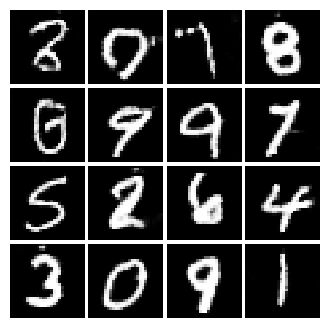

Epoch: 7, Iter: 17500, D: 0.1974, G:0.2662


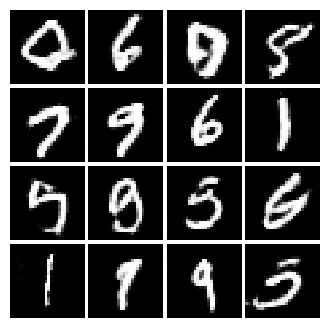

Epoch: 7, Iter: 17600, D: 0.1311, G:0.3228


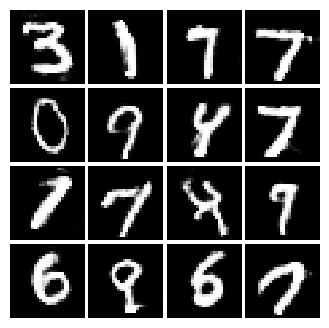

Epoch: 7, Iter: 17700, D: 0.1453, G:0.2974


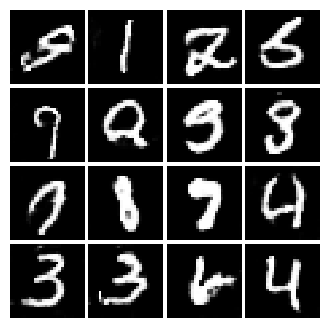

Epoch: 7, Iter: 17800, D: 0.1901, G:0.2369


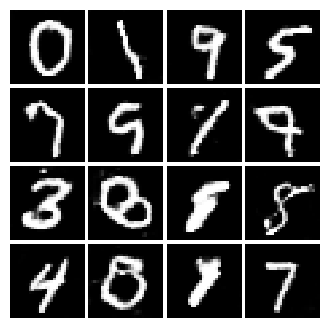

Epoch: 7, Iter: 17900, D: 0.1124, G:0.2764


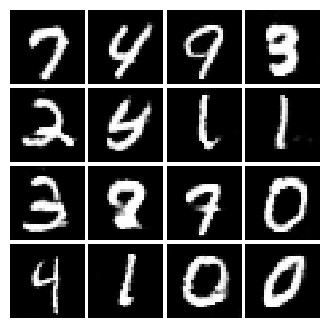

Epoch: 7, Iter: 18000, D: 0.1263, G:0.2921


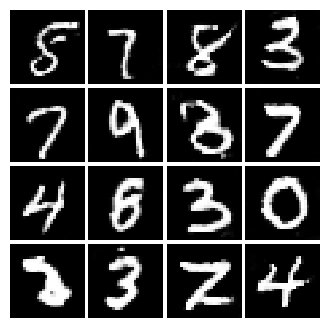

Epoch: 7, Iter: 18100, D: 0.1566, G:0.1985


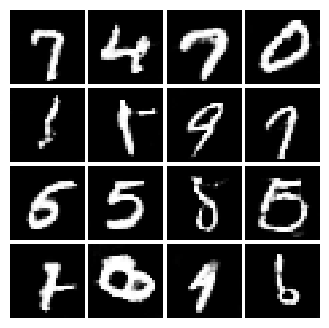

Epoch: 7, Iter: 18200, D: 0.1671, G:0.2656


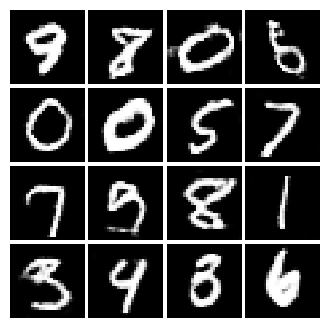

Epoch: 7, Iter: 18300, D: 0.1431, G:0.2549


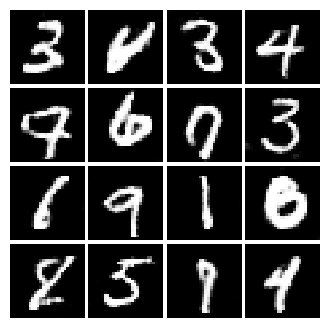

Epoch: 7, Iter: 18400, D: 0.1845, G:0.3854


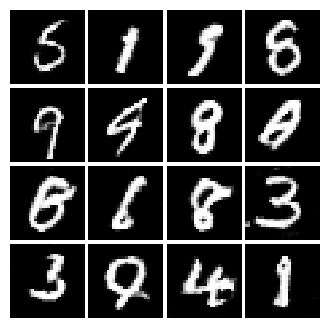

Epoch: 7, Iter: 18500, D: 0.1349, G:0.2447


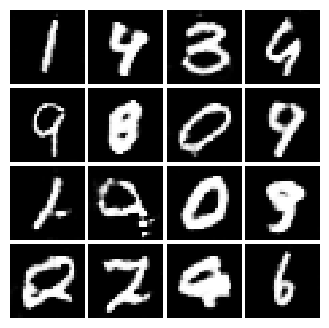

Epoch: 7, Iter: 18600, D: 0.2026, G:0.2687


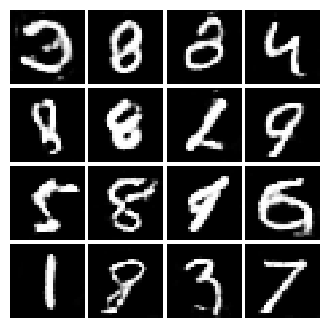

Epoch: 7, Iter: 18700, D: 0.1666, G:0.2709


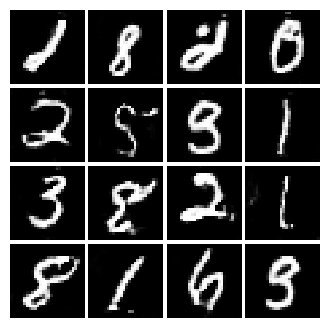

Epoch: 7, Iter: 18800, D: 0.1296, G:0.2896


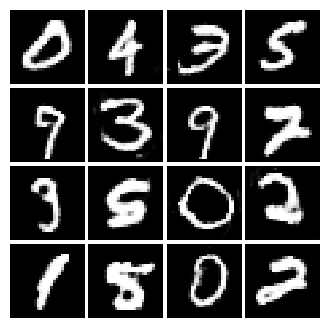

Epoch: 7, Iter: 18900, D: 0.1407, G:0.2047


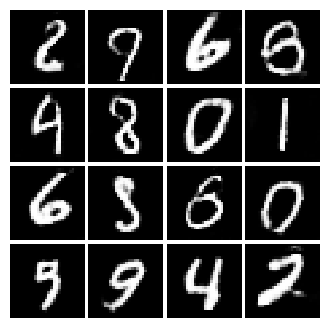

Epoch: 7, Iter: 19000, D: 0.1313, G:0.2621


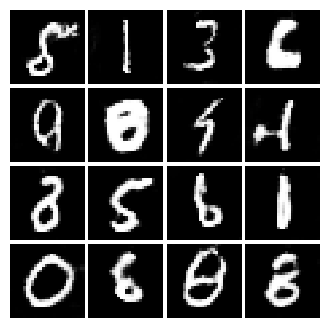

Epoch: 7, Iter: 19100, D: 0.1359, G:0.3415


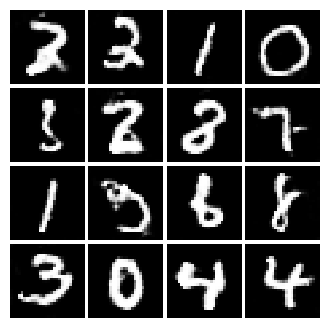

Epoch: 8, Iter: 19200, D: 0.1989, G:0.2105


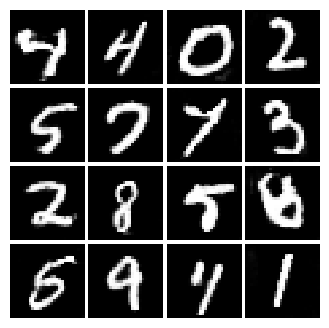

Epoch: 8, Iter: 19300, D: 0.1187, G:0.2546


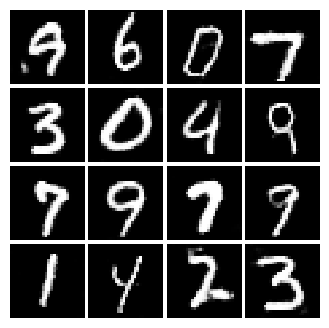

Epoch: 8, Iter: 19400, D: 0.1682, G:0.1887


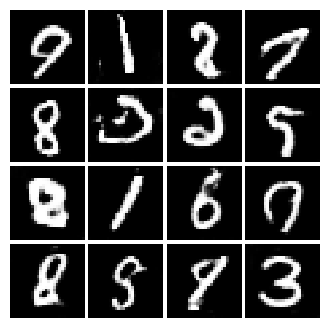

Epoch: 8, Iter: 19500, D: 0.1334, G:0.2661


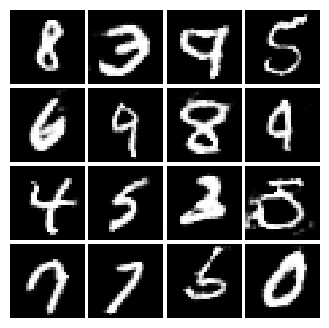

Epoch: 8, Iter: 19600, D: 0.199, G:0.199


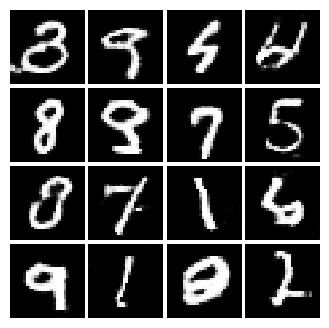

Epoch: 8, Iter: 19700, D: 0.1492, G:0.2249


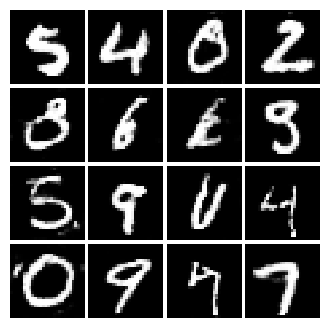

Epoch: 8, Iter: 19800, D: 0.1657, G:0.213


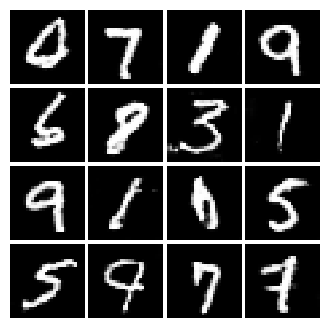

Epoch: 8, Iter: 19900, D: 0.1334, G:0.1729


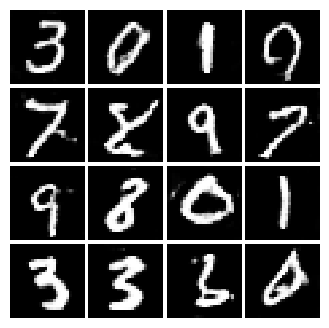

Epoch: 8, Iter: 20000, D: 0.1109, G:0.3283


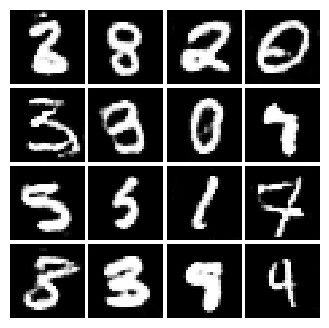

Epoch: 8, Iter: 20100, D: 0.1597, G:0.3506


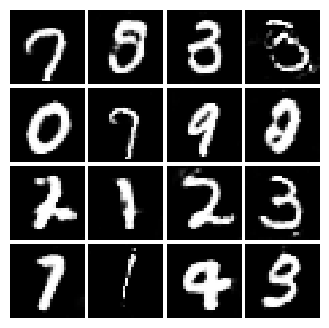

Epoch: 8, Iter: 20200, D: 0.1919, G:0.2933


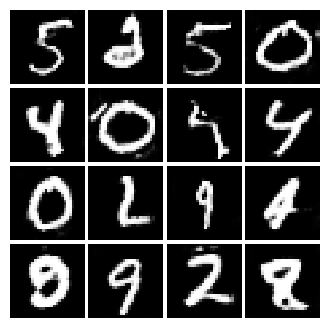

Epoch: 8, Iter: 20300, D: 0.1235, G:0.2075


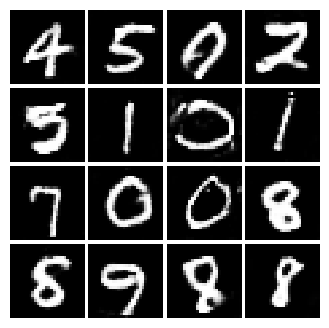

Epoch: 8, Iter: 20400, D: 0.1246, G:0.3632


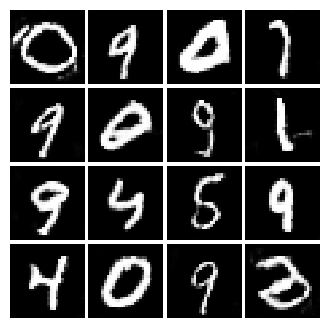

Epoch: 8, Iter: 20500, D: 0.1635, G:0.1423


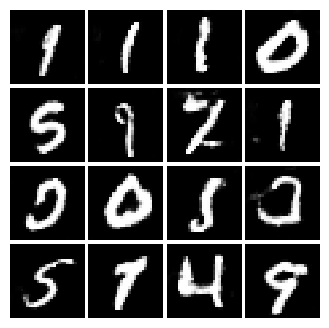

Epoch: 8, Iter: 20600, D: 0.1641, G:0.2403


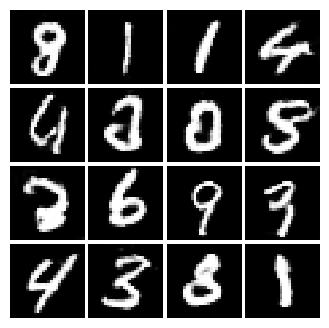

Epoch: 8, Iter: 20700, D: 0.1233, G:0.2342


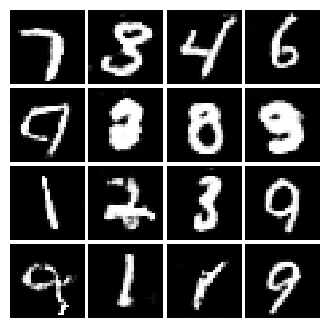

Epoch: 8, Iter: 20800, D: 0.1641, G:0.3742


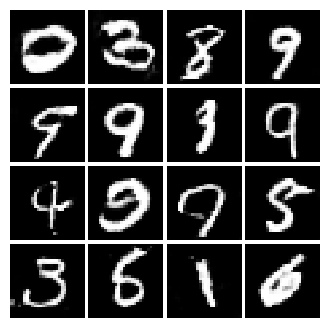

Epoch: 8, Iter: 20900, D: 0.1446, G:0.2865


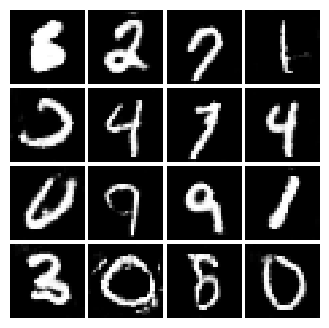

Epoch: 8, Iter: 21000, D: 0.1894, G:0.2421


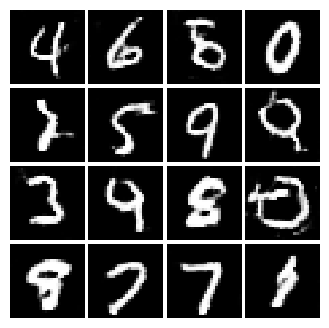

Epoch: 8, Iter: 21100, D: 0.1694, G:0.285


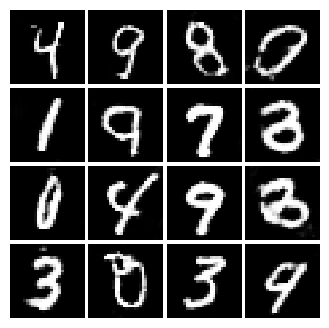

Epoch: 8, Iter: 21200, D: 0.1638, G:0.3421


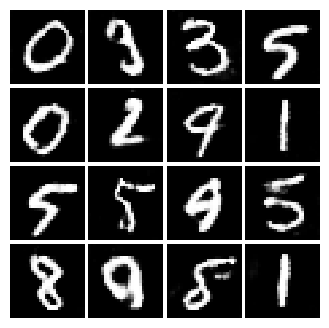

Epoch: 8, Iter: 21300, D: 0.1521, G:0.166


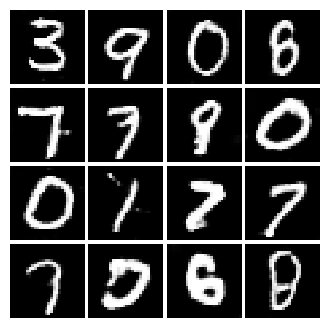

Epoch: 8, Iter: 21400, D: 0.1395, G:0.3572


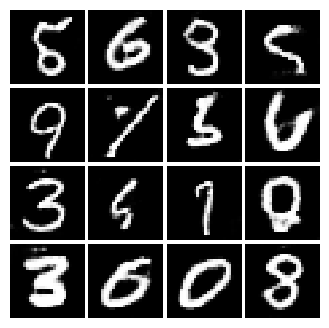

Epoch: 8, Iter: 21500, D: 0.1214, G:0.3908


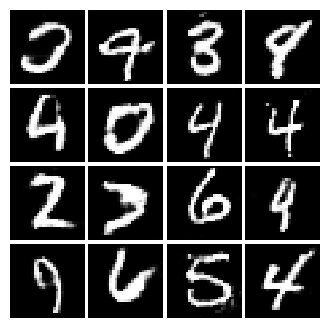

Epoch: 9, Iter: 21600, D: 0.2478, G:0.2029


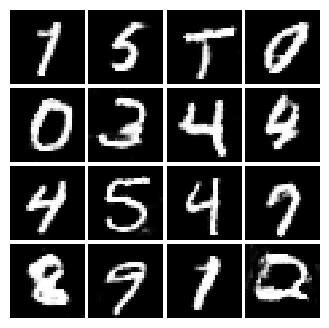

Epoch: 9, Iter: 21700, D: 0.1127, G:0.283


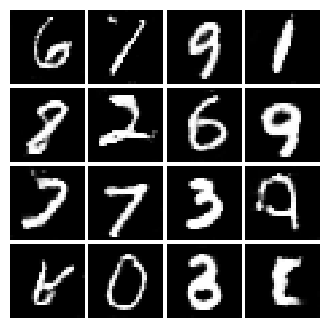

Epoch: 9, Iter: 21800, D: 0.1866, G:0.211


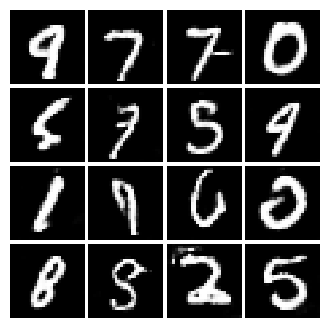

Epoch: 9, Iter: 21900, D: 0.1471, G:0.246


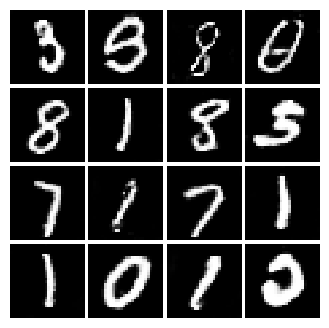

Epoch: 9, Iter: 22000, D: 0.171, G:0.2048


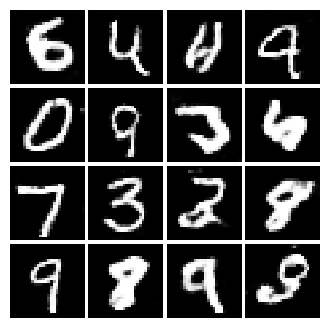

Epoch: 9, Iter: 22100, D: 0.1633, G:0.2389


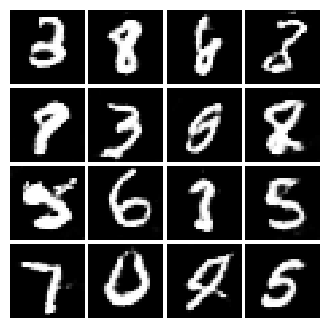

Epoch: 9, Iter: 22200, D: 0.1662, G:0.2453


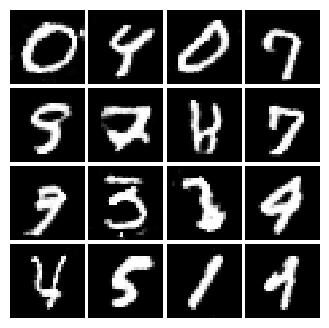

Epoch: 9, Iter: 22300, D: 0.1739, G:0.2227


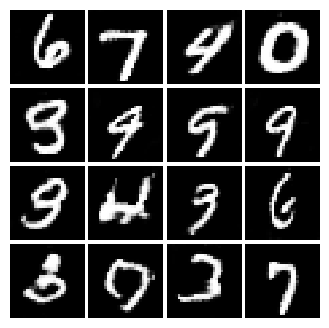

Epoch: 9, Iter: 22400, D: 0.1217, G:0.264


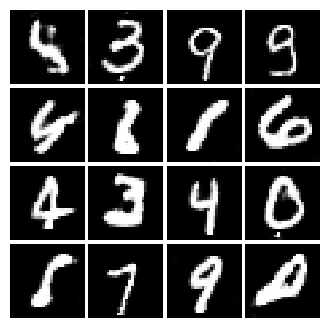

Epoch: 9, Iter: 22500, D: 0.1373, G:0.3063


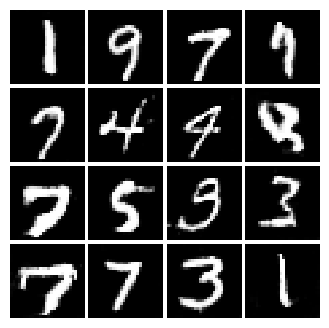

Epoch: 9, Iter: 22600, D: 0.1763, G:0.2527


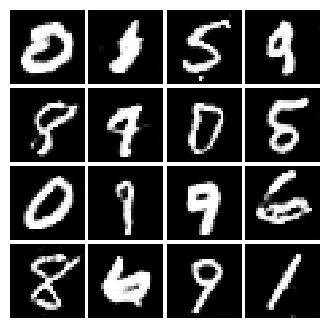

Epoch: 9, Iter: 22700, D: 0.1318, G:0.3227


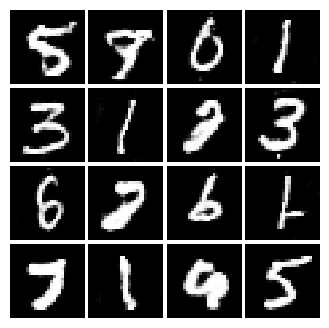

Epoch: 9, Iter: 22800, D: 0.1055, G:0.3003


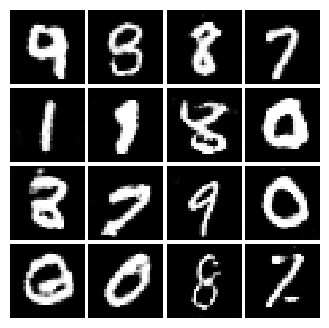

Epoch: 9, Iter: 22900, D: 0.1579, G:0.2199


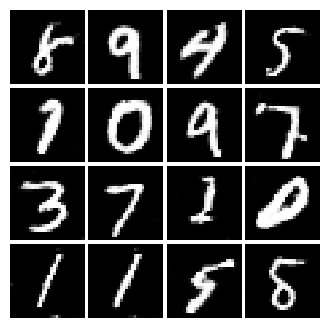

Epoch: 9, Iter: 23000, D: 0.1625, G:0.212


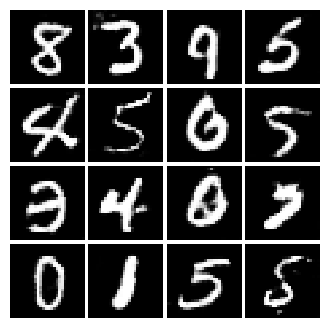

Epoch: 9, Iter: 23100, D: 0.1312, G:0.2177


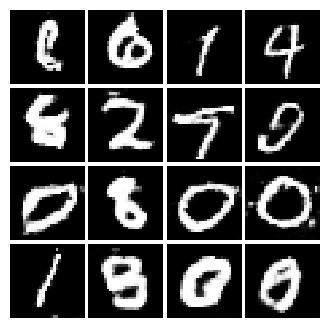

Epoch: 9, Iter: 23200, D: 0.1369, G:0.2956


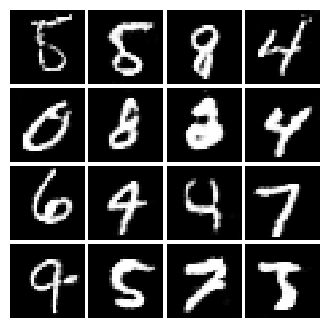

Epoch: 9, Iter: 23300, D: 0.174, G:0.2758


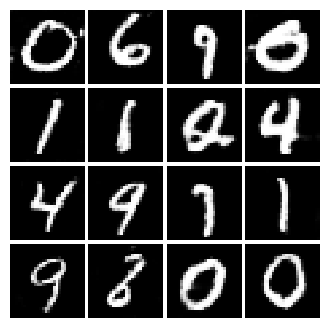

Epoch: 9, Iter: 23400, D: 0.1836, G:0.3016


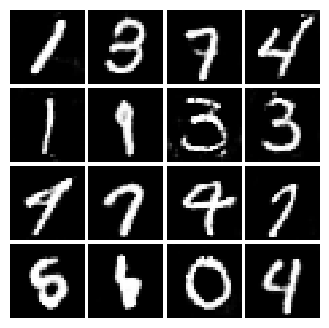

Epoch: 9, Iter: 23500, D: 0.1438, G:0.331


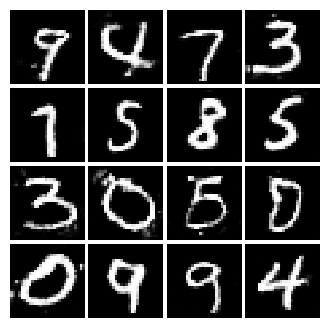

Epoch: 9, Iter: 23600, D: 0.1324, G:0.3342


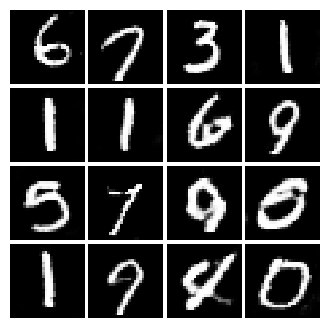

Epoch: 9, Iter: 23700, D: 0.1457, G:0.1247


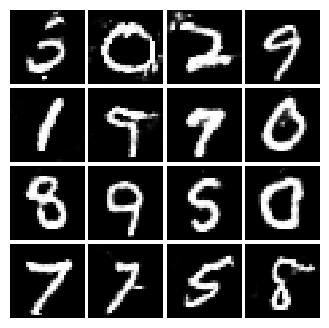

Epoch: 9, Iter: 23800, D: 0.143, G:0.3536


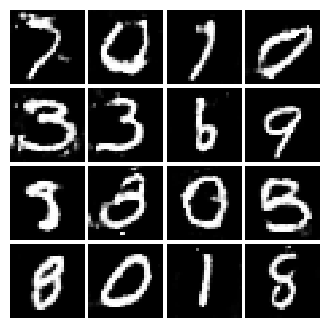

Epoch: 9, Iter: 23900, D: 0.1082, G:0.3698


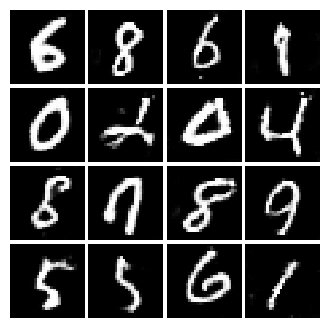

In [7]:
cnt = 0
num_epochs = 10

for epochs in range(num_epochs):
    for (x, y) in dataset:

          for _ in range(1):
              with tf.GradientTape() as disc_tape:

                batch_size = x.shape[0]
                ##Discriminator:
                real_output = Discriminator(2*x - 1, training = True)
                noise = generate_noise(batch_size, 100)
                fake_output = Discriminator(Generator(noise, training = True), training = True)
                #print(fake_output, real_output)
                disc_loss = discriminator_loss(real_output, fake_output)

                gradients_of_discriminator = disc_tape.gradient(disc_loss, Discriminator.trainable_variables)
                Discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, Discriminator.trainable_variables))

          for _ in range(1):
              with tf.GradientTape() as gen_tape:
                noise = generate_noise(x.shape[0], 100)
                fake_output = Discriminator(Generator(noise, training = True), training = True)
                gen_loss = generator_loss(fake_output)
    
                gradients_of_generator = gen_tape.gradient(gen_loss, Generator.trainable_variables)
                Generator_optimizer.apply_gradients(zip(gradients_of_generator, Generator.trainable_variables))

          if (cnt % 100 == 0):
                print('Epoch: {}, Iter: {}, D: {:.4}, G:{:.4}'.format(epochs, cnt, disc_loss, gen_loss))
                imgs_numpy = Generator(noise).cpu().numpy()
                show_images(imgs_numpy[0:16])
                plt.show()

          cnt += 1

Final images


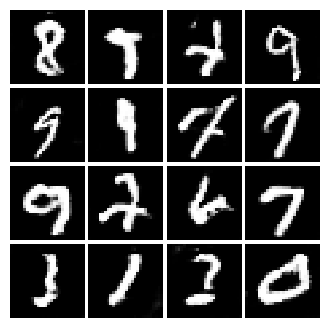

In [17]:
z = generate_noise(25, 100)
G_sample = Generator(z)
print('Final images')
show_images(G_sample[:16])
plt.show()

In [13]:
Generator.save_weights('/kaggle/working/generator.weights.h5')
Discriminator.save_weights('/kaggle/working/discriminator.weights.h5')